LIME is one of the more popular model interpretation algorithms.
Lots of different implementations.
We will do a step by step simplistic implementation here:
Then we'll use an easier to use version of LIME to use in real time.

# Explain Your Predictive Models to Business Stakeholders with LIME Using Python and H2O
In this oriole, an H2O GBM is trained on the UCI credit card default data and then predictions for a highly risky customer are explained using linear model coefficients and LIME-derived reason codes.
By Patrick Hall, January 12, 2018
Describing complex models and generating reason codes with Local Interpretable Model-agnostic Explanations (LIME) and LIME-variants
Local Interpretable Model-agnostic Explanations (LIME) shed light on how almost any machine learning model makes decisions for specific rows of data. LIME builds local linear surrogate models around observations of interest and leverages the highly interpretable properties of linear models to increase transparency and accountability for the corresponding model predictions. In this notebook, an H2O GBM is trained on the UCI credit card default data and then predictions for a highly risky customer are explained using linear model coefficients and LIME-derived reason codes. The notebook concludes by introducing a variant of LIME that is easier to execute on new data and that can be analyzed alongside observed (i.e., not simulated) data.

# Python imports
In general, NumPy and Pandas will be used for data manipulation purposes and H2O will be used for modeling tasks.

In [14]:
#1 - H2O Python API with specific classes
import h2o 
from h2o.estimators.glm import H2OGeneralizedLinearEstimator # for LIME
from h2o.estimators.gbm import H2OGradientBoostingEstimator  # for GBM

import operator # for sorting dictionaries

import numpy as np   # array, vector, matrix calculations
import pandas as pd  # DataFrame handling

# display plots in notebook
%matplotlib inline

h2o is a library and a server

Start H2O
H2O is both a library and a server. The machine learning algorithms in the library take advantage of the multithreaded and distributed architecture provided by the server to train machine learning algorithms extremely efficiently. The API for the library was imported above in cell 1, but the server still needs to be started.

In [15]:
#2
h2o.init(max_mem_size='2G')       # start H2O
h2o.remove_all()                  # remove any existing data structures from h2o memory

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,32 mins 22 secs
H2O cluster timezone:,Europe/London
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.8
H2O cluster version age:,1 month and 6 days
H2O cluster name:,H2O_from_python_Richard_c8s8d6
H2O cluster total nodes:,1
H2O cluster free memory:,1.313 Gb
H2O cluster total cores:,12
H2O cluster allowed cores:,12
H2O cluster status:,"locked, healthy"


**1. Download, explore, and prepare UCI credit card default data**
UCI credit card default data is available here.

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables:

LIMIT_BAL: Amount of given credit (NT dollar)
SEX: 1 = male; 2 = female
EDUCATION: 1 = graduate school; 2 = university; 3 = high school; 4 = others
MARRIAGE: 1 = married; 2 = single; 3 = others
AGE: Age in years
PAY_0, PAY_2 - PAY_6: History of past payment; PAY_0 = the repayment status in September 2005; PAY_2 = the repayment status in August 2005; ...; PAY_6 = the repayment status in April 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above.
BILL_AMT1 - BILL_AMT6: Amount of bill statement (NT dollar). BILL_AMNT1 = amount of bill statement in September 2005; BILL_AMT2 = amount of bill statement in August 2005; ...; BILL_AMT6 = amount of bill statement in April 2005.
PAY_AMT1 - PAY_AMT6: Amount of previous payment (NT dollar). PAY_AMT1 = amount paid in September 2005; PAY_AMT2 = amount paid in August 2005; ...; PAY_AMT6 = amount paid in April 2005.
These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005.

Because H2O accepts both numeric and character inputs, some variables will be recoded into more transparent character values.

**Import data and clean **
The credit card default data is available as an .xls file. Pandas reads .xls files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: DEFAULT_NEXT_MONTH.

Lets use a complex GBM model to predict credit card defaults. 

Pay_0 - Pay_6 : status for most recent payment. 
Did they pay on time
Were they late
were they several months late

In [16]:
#3 - import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1)

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'})

**Assign modeling roles**
The shorthand name y is assigned to the prediction target. X is assigned to all other input variables in the credit card default data except the row identifier, ID.

In [17]:
#4 - assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


RUN
Helper function for recoding values in the UCI credit card default data
This simple function maps longer, more understandable character string values from the UCI credit card default data dictionary to the original integer values of the input variables found in the dataset. These character values can be used directly in H2O decision tree models, and the function returns the original Pandas DataFrame as an H2O object, an H2OFrame. H2O models cannot run on Pandas DataFrames. They require H2OFrames.

In [18]:
d=data.head()
d.T

,0,1,2,3,4
ID,1,2,3,4,5
LIMIT_BAL,20000,120000,90000,50000,50000
SEX,2,2,2,2,1
EDUCATION,2,2,2,2,2
MARRIAGE,1,2,2,1,1
AGE,24,26,34,37,57
PAY_0,2,-1,0,0,-1
PAY_2,2,2,0,0,0
PAY_3,-1,0,0,0,-1
PAY_4,-1,0,0,0,0


NB. We convert the pandas df to an h2o df at end of function:

In [19]:
#5
def recode_cc_data(frame):

    """ Recodes numeric categorical variables into categorical character variables
    with more transparent values. 

    Args:
        frame: Pandas DataFrame version of UCI credit card default data.

    Returns: 
        H2OFrame with recoded values.

    """

    # define recoded values
    sex_dict = {1:'male', 2:'female'}
    education_dict = {0:'other', 1:'graduate school', 2:'university', 3:'high school', 
                      4:'other', 5:'other', 6:'other'}
    marriage_dict = {0:'other', 1:'married', 2:'single', 3:'divorced'}
    pay_dict = {-2:'no consumption', -1:'pay duly', 0:'use of revolving credit', 1:'1 month delay', 
                2:'2 month delay', 3:'3 month delay', 4:'4 month delay', 5:'5 month delay', 6:'6 month delay', 
                7:'7 month delay', 8:'8 month delay', 9:'9+ month delay'}

    # recode values using Pandas apply() and anonymous function
    frame['SEX'] = frame['SEX'].apply(lambda i: sex_dict[i])
    frame['EDUCATION'] = frame['EDUCATION'].apply(lambda i: education_dict[i])    
    frame['MARRIAGE'] = frame['MARRIAGE'].apply(lambda i: marriage_dict[i]) 
    for name in frame.columns:
        if name in ['PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']:
            frame[name] = frame[name].apply(lambda i: pay_dict[i])            

    return h2o.H2OFrame(frame)

data = recode_cc_data(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


Ensure target is handled as a categorical variable
In H2O, a numeric variable can be treated as numeric or categorical. The target variable DEFAULT_NEXT_MONTH takes on values of 0 or 1. To ensure that this numeric variable is treated as a categorical variable, the asfactor() function is used to explicitly declare that it is a categorical variable.

Target variable cat column needs to be explicitly declared as a categorical  variable because despite being binary 0/1 pandas and h2o would recognise as numeric (incorrectly).

In [20]:
#6
data[y] = data[y].asfactor()

Display descriptive statistics
The H2O describe() function displays a brief description of the credit card default data. For the categorical input variables LIMIT_BAL, SEX, EDUCATION, MARRIAGE, and PAY_0-PAY_6, the new character values created above in cell 5 are visible. Basic descriptive statistics are displayed for numeric inputs.

In [23]:
#7
data.describe()

Rows:30000
Cols:25




,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
type,int,int,enum,enum,enum,int,enum,enum,enum,enum,enum,enum,int,int,int,int,int,int,int,int,int,int,int,int,enum
mins,1.0,10000.0,,,,21.0,,,,,,,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0,0.0,0.0,0.0,0.0,0.0,0.0,
mean,15000.5,167484.32266666615,,,,35.48549999999997,,,,,,,51223.33089999999,49179.07516666671,47013.15479999975,43262.94896666657,40311.40096666653,38871.76039999989,5663.580500000012,5921.163500000002,5225.6815000000115,4826.076866666665,4799.387633333305,5215.502566666666,
maxs,30000.0,1000000.0,,,,79.0,,,,,,,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0,
sigma,8660.398374208891,129747.66156720235,,,,9.217904068090167,,,,,,,73635.86057552959,71173.76878252836,69349.38742703672,64332.85613391646,60797.155770264806,59554.10753674582,16563.280354025756,23040.870402057226,17606.961469803104,15666.159744031977,15278.305679144802,17777.465775435325,
zeros,0,0,,,,0,,,,,,,2008,2506,2870,3195,3506,4020,5249,5396,5968,6408,6703,7173,
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,1.0,20000.0,female,university,married,24.0,2 month delay,2 month delay,pay duly,pay duly,no consumption,no consumption,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2.0,120000.0,female,university,single,26.0,pay duly,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,2 month delay,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3.0,90000.0,female,university,single,34.0,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0


2. Train an H2O GBM classifier
Split data into training and test sets for early stopping
The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is also an important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [24]:
#8 - split into training and validation
train, test = data.split_frame([0.7], seed=12345)

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 21060, columns = 25
Test data rows = 8940, columns = 25


Train H2O GBM classifier
Many tuning parameters must be specified to train a GBM using H2O. Typically, a grid search would be performed to identify the best parameters for a given modeling task using the H2OGridSearch class. For brevity's sake, a previously discovered set of good tuning parameters are specified here. Because gradient boosting methods typically resample training data, an additional random seed is also specified for the H2O GBM using the seed parameter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the stopping_rounds parameter is used to stop the training process after the test error fails to decrease for 5 iterations.

In [25]:
#9 - initialize GBM model
model = H2OGradientBoostingEstimator(ntrees=150,            # maximum 150 trees in GBM
                                     max_depth=4,           # trees can have maximum depth of 4
                                     sample_rate=0.9,       # use 90% of rows in each iteration (tree)
                                     col_sample_rate=0.9,   # use 90% of variables in each iteration (tree)
                                     stopping_rounds=5,     # stop if validation error does not decrease for 5 iterations (trees)
                                     score_tree_interval=1, # for reproducibility, set higher for bigger data
                                     seed=12345)            # random seed for reproducibility

# train a GBM model
model.train(y=y, x=X, training_frame=train, validation_frame=test)

# print AUC
print('GBM Test AUC = %.2f' % model.auc(valid=True))

gbm Model Build progress: |███████████████████████████████████████████████| 100%
GBM Test AUC = 0.78


3. **Use LIME to generate descriptions for a local region with a perturbed sample**
LIME was originally described in the context of explaining image or text classification decisions here. It can certainly also be applied to business or customer data, as will be done in the remaining sections of this notebook. Multiple Python implementations of LIME are available from the original authors of LIME, from the eli5 package, from the skater package, and probably others. However, this notebook uses a simple, step-by-step implementation of LIME for instructional purposes.

A linear model cannot be built on a single observation, so LIME typically requires that a set of rows similar to the row of interest be simulated. This set of records are scored using the complex model to be explained. Then the records are weighted by their closeness to the record of interest, and a regularized linear model is trained on this weighted explanatory set. The parameters of the linear model and LIME-derived reason codes are then used to explain the prediction for the selected record. Because simulation of new points can seem abstract to some practitioners and simulation and distance calculations can be somewhat burdensome for creating explanations quickly in mission-critical applications, this notebook also presents a variation of LIME in which a more practical sample, instead of a perturbed, simulated sample, is used to create a local region in which to fit a linear model.

**Display the most risky customer**
In the Oriole notebook Increase Transparency and Accountability in Your Machine Learning Project with Python and H2O, row index 29116 was found to contain the riskiest customer in the test dataset according to the H2O GBM model. Sections 3-7 focus on deriving reason codes and other explanations for this customer's GBM prediction. The riskiest customer is selected first for analysis, as an exercise in boundary testing.

LIME : Local. We want to understand a very specific region of the conditional distribution, or specific prediction that the model makes.

In [26]:
#10
row = test[test['ID'] == 29116]
row

ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
29116,20000,female,university,married,59,3 month delay,2 month delay,3 month delay,2 month delay,2 month delay,4 month delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,1


To use LIME, a sample of similar (i.e., near or local) points is simulated around the customer of interest. This simple function draws numeric values from normal distributions centered around the customer of interest and draws categorical values at random from the variable values in the test set.

We want to describe the model around this row using more simple linear models. However we can't produce a linear model using just one row!
LIME perscribes that we make a sample of similar rows to our row of interest. 
We do this by sampling from normal distributions for numeric values around the row we're interested in and for cat vars we just draw randomly.

In [27]:
#11
def generate_local_sample(row, frame, X, N=1000):

    """ Generates a perturbed sample around a row of interest.

    Args:
        row: Row of H2OFrame to be explained.
        frame: H2OFrame in which row is stored.
        X: List of model input variables.
        N: Number of samples to generate.

    Returns:
        Pandas DataFrame containing perturbed sample.

    """

    # initialize Pandas DataFrame
    sample_frame = pd.DataFrame(data=np.zeros(shape=(N, len(X))), columns=X)

    # generate column vectors of 
    # randomly drawn levels for categorical variables
    # normally distributed numeric values around mean of column for numeric variables
    for key, val in frame[X].types.items():
        if val == 'enum': # 'enum' means categorical
            rs = np.random.RandomState(11111) # random seed for reproducibility
            draw = rs.choice(frame[key].levels()[0], size=(1, N))[0]
        else:
            rs = np.random.RandomState(11111) # random seed for reproducibility
            loc = row[key][0, 0]
            sd = frame[key].sd()
            draw = rs.normal(loc, sd, (N, 1))
            draw[draw < 0] = loc # prevents unrealistic values when std. dev. is large

        sample_frame[key] = draw

    return sample_frame

# run and display results
perturbed_sample = generate_local_sample(row, test, X)
perturbed_sample.head(n=3)

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,9988.454213,female,graduate school,divorced,58.287510,5 month delay,5 month delay,5 month delay,5 month delay,6 month delay,...,5433.340804,6276.576876,8055.530587,7347.467911,1597.834490,0.000000,1000.000000,823.253257,0.000000,0.000000
1,181039.642122,male,high school,married,70.460689,pay duly,pay duly,pay duly,pay duly,use of revolving credit,...,94937.888614,90412.278099,87766.906051,85915.192926,22137.303918,25583.930273,21802.010398,20928.433066,19123.775929,22563.515833
2,20000.000000,male,university,single,43.284233,7 month delay,7 month delay,7 month delay,7 month delay,8 month delay,...,10672.000000,11201.000000,12721.000000,11946.000000,2800.000000,0.000000,1000.000000,2000.000000,0.000000,0.000000


**Calculate distance between row of interest and perturbed sample**
Once the sample is simulated, then distances from the point of interest are used to weigh each point before fitting a penalized regression model. Since Euclidean distance calculations require numeric quanitites, categorical input variables are one-hot encoded. (Pandas has convenient functionality for one-hot encoding, and the H2OFrames are temporarily cast back to Pandas DataFrames to perform the encoding.) To prevent the disparate scales of numeric values, such as AGE and LIMIT_BAL, from skewing Euclidean distances, numeric input variables are standardized.

First, the row containing the riskiest customer is encoded and standardized:

Now LIME tells us to find the distance between the row we're interested in and these simulated rows.
Couple of problems:
We don't want massively disparate scales to be taking over the distance calculations.
We need to take our cat vars and turn them into meaningful numeric representations.
Do for person of interest and set of samples.
Switch back from h20 to pandas to use get dummies func. Good for teaching purposes (not much code) but not suitable for production mind.
Now switch back to h2o for nice distance function.

In [28]:
#12 - scaling and one-hot encoding for calculating Euclidian distance
# for the row of interest

# scale numeric
numeric = list(set(X) - set(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
                             'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT_NEXT_MONTH']))

scaled_test = test.as_data_frame()
scaled_test[numeric] = (scaled_test[numeric] - scaled_test[numeric].mean())/scaled_test[numeric].std()

# encode categorical
row_df = scaled_test[scaled_test['ID'] == 22760]
row_dummies = pd.concat([row_df.drop(['ID', 'SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0', 'PAY_2',
                                      'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'DEFAULT_NEXT_MONTH'], axis=1),
                        pd.get_dummies(row_df[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                               'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']])], 
                        axis=1)

# convert to H2OFrame
row_dummies = h2o.H2OFrame(row_dummies)
row_dummies

Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_female,EDUCATION_graduate school,MARRIAGE_married,PAY_0_3 month delay,PAY_2_2 month delay,PAY_3_2 month delay,PAY_4_3 month delay,PAY_5_3 month delay,PAY_6_3 month delay
2.24639,0.481433,-0.66112,-0.657958,-0.651883,-0.637776,-0.622867,-0.609179,-0.360791,-0.282325,-0.315203,-0.319038,-0.319074,-0.270536,1,1,1,1,1,1,1,1,1


Then the simulated sample is encoded and standardized:

In [33]:
#13 - scaling and one-hot encoding for calculating Euclidian distance 
# for the simulated sample

# scale
scaled_perturbed_sample = perturbed_sample[numeric].copy(deep=True)
scaled_perturbed_sample = (scaled_perturbed_sample - scaled_perturbed_sample.mean())/scaled_perturbed_sample.std()

# encode
perturbed_sample_dummies = pd.concat([scaled_perturbed_sample,
                                      pd.get_dummies(perturbed_sample[['SEX', 'EDUCATION', 'MARRIAGE', 'PAY_0',
                                                                       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6']])],
                                     axis=1)

# convert to H2OFrame
perturbed_sample_dummies = h2o.H2OFrame(perturbed_sample_dummies[row_dummies.columns])
perturbed_sample_dummies.head(rows=3)

Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,SEX_female,EDUCATION_graduate school,MARRIAGE_married,PAY_0_3 month delay,PAY_2_2 month delay,PAY_3_2 month delay,PAY_4_3 month delay,PAY_5_3 month delay,PAY_6_3 month delay
-0.845634,-0.0955699,-0.84979,-0.845174,-0.845174,-0.83886,-0.834367,-0.834967,-0.83834,-0.723503,-0.722209,-0.849042,-0.723503,-0.723503,1,1,0,0,0,0,0,0,0
1.41903,1.2011,1.41949,1.41897,1.41897,1.4182,1.4176,1.41769,1.41814,1.41999,1.41993,1.41941,1.41999,1.41999,0,0,1,0,0,0,0,0,0
-0.713084,-1.69369,-0.716971,-0.712654,-0.712654,-0.706755,-0.70256,-0.70312,-0.706269,-0.723503,-0.722209,-0.716271,-0.723503,-0.723503,0,0,0,0,0,0,0,0,0


Distance is calculated using H2O. The distance is subtracted from the maximum distance, changing the distance values into similarity values. Now the observations with the highest values are those that are closest to the observation of interest, and they will carry the most weight in the local explanatory linear model. A few sample similarity values are displayed directly next:

Euclidean distances between the person of interest and all the simulations.

NB. We have converted from distance to similarity
ie. people that are closest get weighed the most in our local regression
and the peope that are furthest get weighed the least in our local reg.
by making distances relative to max distance.

In [32]:
#14 - calculate distance using H2OFrame distance function
distance = row_dummies.distance(perturbed_sample_dummies, measure='l2').transpose()
distance.columns = ['distance']          # rename 
distance = distance.max() - distance     # lower distances, higher weight in LIME
distance.head(rows=3)

distance
287.907
253.673
282.757


**Bind distance weights onto perturbed sample**
To fit an H2O linear model using the similarities as observation weights, the distance column must reside in the same H2OFrame as the simulated sample data.

In [34]:
#15 Column bind distances. 
perturbed_sample = h2o.H2OFrame(perturbed_sample).cbind(distance)
perturbed_sample.head(rows=3)

Parse progress: |█████████████████████████████████████████████████████████| 100%


LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,distance
9988.45,female,graduate school,divorced,58.2875,5 month delay,5 month delay,5 month delay,5 month delay,6 month delay,6 month delay,3152.62,5678.04,5433.34,6276.58,8055.53,7347.47,1597.83,0,1000,823.253,0,0,287.907
181040,male,high school,married,70.4607,pay duly,pay duly,pay duly,pay duly,use of revolving credit,use of revolving credit,99691.6,98946.5,94937.9,90412.3,87766.9,85915.2,22137.3,25583.9,21802,20928.4,19123.8,22563.5,253.673
20000,male,university,single,43.2842,7 month delay,7 month delay,7 month delay,7 month delay,8 month delay,8 month delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,282.757


**Bind model predictions onto perturbed sample**
For LIME, the target of the explanatory local linear model are the predictions of the GBM model in the local simulated sample. The values are calculated and column-bound to the simulated sample.

#Explanatory Local regression model: Target of local model to explain complex model is predictions of complex model
cbind preds


In [35]:
#16
yhat = 'p_DEFAULT_NEXT_MONTH'
preds1 = model.predict(perturbed_sample).drop(['predict', 'p0'])
preds1.columns = [yhat]
perturbed_sample = perturbed_sample.cbind(preds1)
perturbed_sample.head(rows=3)

gbm prediction progress: |████████████████████████████████████████████████| 100%


LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,distance,p_DEFAULT_NEXT_MONTH
9988.45,female,graduate school,divorced,58.2875,5 month delay,5 month delay,5 month delay,5 month delay,6 month delay,6 month delay,3152.62,5678.04,5433.34,6276.58,8055.53,7347.47,1597.83,0,1000,823.253,0,0,287.907,0.515197
181040,male,high school,married,70.4607,pay duly,pay duly,pay duly,pay duly,use of revolving credit,use of revolving credit,99691.6,98946.5,94937.9,90412.3,87766.9,85915.2,22137.3,25583.9,21802,20928.4,19123.8,22563.5,253.673,0.0663977
20000,male,university,single,43.2842,7 month delay,7 month delay,7 month delay,7 month delay,8 month delay,8 month delay,8803,11137,10672,11201,12721,11946,2800,0,1000,2000,0,0,282.757,0.692681


**Train penalized linear model in local region**
Once the simulated sample has been weighted with distances and contains the GBM model predictions, a linear model is fit to the original inputs and the GBM model predictions, weighted by similarity to the row of interest. The trained GLM coefficients are helpful for understanding the local region of response function around the riskiest customer.

Train a linear model on set of peopel like our target person to get an idea of what's the average behaviour of the response function for the region we're interested in.

We train a penalised model which prevents corr between vars and will do some var selection if necessary.

We print out what the highest +ve coefficients are ie. the vars that are driving people towards the higher probability of default.

We see in this region, 5 and 6th most region payments are driving people to default in this region.

We want to do better than saying on average. We want to say what's going on for this one subject of interest.

In [36]:
#17 - initialize
local_glm1 = H2OGeneralizedLinearEstimator(lambda_search=True, 
                                           weights_column='distance',
                                           seed=12345)
# train 
local_glm1.train(x=X, y=yhat, training_frame=perturbed_sample)

# coefs
print('\nLocal Positive GLM Coefficients:')
for c_name, c_val in sorted(local_glm1.coef().items(), key=operator.itemgetter(1)):
    if c_val > 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))

# r2
print('\nLocal GLM R-square:\n%.2f' % local_glm1.r2())

glm Model Build progress: |███████████████████████████████████████████████| 100%

Local Positive GLM Coefficients:
PAY_6.5 month delay:      0.00012336828327573496
PAY_6.8 month delay:      0.00017180686755454105
AGE:                      0.0005214813169894424
MARRIAGE.divorced:        0.0009908636978080935
PAY_5.5 month delay:      0.0029210607400757278
PAY_5.8 month delay:      0.0034766652812415477
MARRIAGE.married:         0.008394498329108364
EDUCATION.graduate school: 0.008778594515508074
PAY_4.8 month delay:      0.009194057851983514
PAY_6.2 month delay:      0.010989810282325953
PAY_3.8 month delay:      0.011784255155208112
PAY_4.4 month delay:      0.013724839005142249
PAY_2.8 month delay:      0.015148689640083085
PAY_3.4 month delay:      0.015894167507824547
EDUCATION.high school:    0.017278858933902488
PAY_0.8 month delay:      0.01866577067320307
PAY_2.4 month delay:      0.018836208439562376
PAY_5.2 month delay:      0.021213743679601365
PAY_0.4 month delay:      0.022

The coefficients of the local linear model describe the average behavior of the GBM response function around the riskiest customer. In this local region, customers who missed payments, particularly PAY_0, PAY_5, and PAY_6, are treated as the most likely to default.

**4. Generate reason codes with LIME based on a perturbed sample**
This basic function uses the coefficients of the local linear explanatory model and the values in the row of interest to plot reason code values in a bar chart. The local GLM coefficient multiplied by the value in a specific row are estimates of how much each variable contributed to each prediction decision. These values can tell you how a variable and its values were weighted in any given decision by the model. These values are crucially important for machine learning interpretability and are often to referred to "local feature importance," "reason codes," or "turn-down codes." The latter phrases are borrowed from credit scoring. Credit lenders in the US must provide reasons for turning down certain credit applications in an automated fashion. Reason codes can be easily extracted from LIME local feature importance values by simply ranking the variables that played the largest role in any given decision.

Lets create reason or turn down codes for this one person.
Just gets value for row * coefficient in model and do bar chart.

In [38]:
#18
def plot_local_contrib(row, model, X): 

    """ Plots reason codes in a bar chart. 

    Args:

        row: Row of H2OFrame to be explained.
        model: H2O linear model used for generating reason codes.
        X: List of model input variables.

    """

    # initialize Pandas DataFrame to store results
    local_contrib_frame = pd.DataFrame(columns=['Name', 'Local Contribution', 'Sign'])

    # multiply values in row by local glm coefficients    
    for key, val in sorted(row[X].types.items()):
        contrib = 0
        name = ''
        if val == 'enum':
                level = row[key][0, 0]
                name = '.'.join([str(key), str(level)])
                if name in model.coef():
                    contrib = model.coef()[name]
        else:
            name = key
            if name in model.coef():
                contrib = row[name][0, 0]*model.coef()[name]

        # save only non-zero values
        if contrib != 0.0:
            local_contrib_frame = local_contrib_frame.append({'Name': name,
                                                              'Local Contribution': contrib,
                                                              'Sign': contrib > 0}, 
                                                             ignore_index=True) 

    # plot
    _ = local_contrib_frame.plot(x='Name',
                                 y='Local Contribution',
                                 kind='bar', 
                                 title='Reason Codes', 
                                 color=''.join(local_contrib_frame.Sign.map({True:'b', False:'g'}).values), 
                                 legend=False)

**Display reason codes**
Here it can be seen that the riskiest customer's prediction is driven by her values for payment variables. Specifically, the top five LIME-derived reason codes contributing to her high probability of default are:
- 
Most recent payment is 3 months delayed.
- 2nd most recent payment is 2 months delayed.
- 3rd most recent payment is 3 months delayed.
- Customer Age is 59.
- 4th most recent payment is 2 months delayed.
(Of course, in many places, variables like MARRIAGE, AGE, and SEX cannot be used in credit lending decisions.)
- 
This result is somewhat aligned with LOCO-derived reason codes found in section 5 of the Increase Transparency and Accountability in Your Machine Learning Project with Python and H2O Oriole notebook. Both perspectives weigh the riskiest customer's most recent and third most recent payments very heavily in the model's prediction. A minor discrepancy between LOCO- and LIME-derived reason codes is somewhat expected. LIME explanations are linear, do not consider interactions, and represent offsets from the local linear model intercept. LOCO importance values are nonlinear, do consider interactions, and do not explicitly consider a linear intercept or offset. Because most currently available explanatory techniques are approximate, it is recommended that users employ several different explanatory techniques and trust only consistent results across techniques.

It is also imperative to compare these results to domain knowledge and reasonable expectations. In this case, the LIME reason codes and linear model coefficients tell a relatively parsimonious story about the GBM's prediction behavior. If this was not so, steps should be taken to either reconcile or remove inconsistencies and unreasonable predictions.

We are not saying these are important vars in the model but we are saying this is why the model made these reasons for this one person.

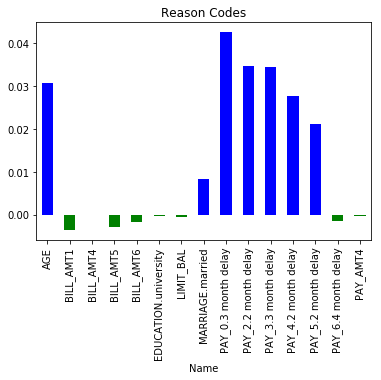

In [39]:
#19
plot_local_contrib(row, local_glm1, X)

5. Use LIME to generate descriptions for a local region with a practical sample
Using a previously existing local sample based on clusters, deciles, or other more natural segments to create LIME explanations is computationally cheaper and perhaps more straightforward than using a simulated perturbed sample, but it does have one major drawback. If the sample is too large, the explanatory linear model maybe not be accurate enough to explain all predictions in the sample. The remaining sections of this notebook will explore the idea of generating LIME explanations using a practical sample.

Create a local region based on values of SEX and merge with GBM model predictions
Instead of using a perturbed simulated sample, a linear model will be fit on all women in the test set, and the sample is not weighted by distance from any one point. A few lines of the all-female sample are displayed directly next.

Real time production LIME version.
Instead of simulatingg a perturbed sample (ie. generating sample, calc distinces to fit model etc.) 

Quicker reason codes why.
Let make a practical sample eg. Lets select all women in sample as the local region around her.


In [40]:
#20
preds2 = model.predict(test).drop(['predict', 'p0'])
preds2.columns = [yhat]
practical_sample = test.cbind(preds2)
practical_sample = practical_sample[practical_sample['SEX'] == 'female']
practical_sample.head(rows=3)

gbm prediction progress: |████████████████████████████████████████████████| 100%


ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH
4,50000,female,university,married,37,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,46990,48233,49291,28314,28959,29547,2000,2019,1200,1100,1069,1000,0,0.144991
8,100000,female,university,single,23,use of revolving credit,pay duly,pay duly,use of revolving credit,use of revolving credit,pay duly,11876,380,601,221,-159,567,380,601,0,581,1687,1542,0,0.128193
16,50000,female,high school,divorced,23,1 month delay,2 month delay,use of revolving credit,use of revolving credit,use of revolving credit,use of revolving credit,50614,29173,28116,28771,29531,30211,0,1500,1100,1200,1300,1100,0,0.325205


**Train penalized linear model in local region**
A penalized linear model is trained in the local region defined by women in the test set. Because fit is a concern in this much larger explanatory sample, users should always check the R2 or other goodness-of-fit measures to ensure that the surrogate model is accurate in the sample.

Train pernalized LM
Don't bother with weighing distances from subject also (because quite time consuming)
Also model can work for all females coming through in future.

We see some of the same patterns.
Let's check the R^2. We don't have the same control over sample size here ie. Need to check local model fitting well.

In [41]:
#21 - initialize
local_glm2 = H2OGeneralizedLinearEstimator(lambda_search=True, seed=12345)

# train 
local_glm2.train(x=X, y=yhat, training_frame=practical_sample)

# coefs
print('\nLocal Positive GLM Coefficients:')
for c_name, c_val in sorted(local_glm2.coef().items(), key=operator.itemgetter(1)):
    if c_val > 0.0:
        print('%s %s' % (str(c_name + ':').ljust(25), c_val))

# r2
print('\nLocal GLM R-square:\n%.2f' % local_glm2.r2())

glm Model Build progress: |███████████████████████████████████████████████| 100%

Local Positive GLM Coefficients:
BILL_AMT5:                1.1826997991307655e-07
BILL_AMT2:                1.4086640911732477e-07
PAY_2.use of revolving credit: 8.019899526885406e-05
PAY_5.no consumption:     0.0005253910928097832
AGE:                      0.0005358697742774514
EDUCATION.high school:    0.0017389457065927808
PAY_6.5 month delay:      0.0037460607056171388
EDUCATION.university:     0.005086923372619536
MARRIAGE.divorced:        0.008137713429374492
PAY_3.2 month delay:      0.009655714764486612
PAY_6.7 month delay:      0.009949478307879608
MARRIAGE.married:         0.010783461117748147
PAY_6.2 month delay:      0.017777285984774575
PAY_4.4 month delay:      0.018246956356756164
PAY_0.5 month delay:      0.02282693801075063
PAY_5.3 month delay:      0.02513913532234377
PAY_2.2 month delay:      0.027053294000841926
PAY_2.3 month delay:      0.02773531490325982
PAY_3.3 month delay:      0.

The R2 is quite high for this local sample and linear model. Because the sample is simply the women in the test set and because the model fit is acceptable, the trained linear model and coefficients can be used to understand the average behavior of women in the test set. On average, late payments, particularly PAY_0, PAY_2, and PAY_6, are the most likely to push the GBM model towards higher probability of default values for women.

6. Generate a ranked predictions plot to assess validity of local explanatory model
A ranked predictions plot can also be used to ensure the local linear surrogate model is a good fit for the model inputs and predictions. A ranked predictions plot is a way to visually check whether the surrogate model is a good fit for the complex model. The y-axis is the numeric prediction of both models for a given point. The x-axis is the rank of a point when the predictions are sorted by their GBM prediction, from lowest on the left to highest on the right. When both sets of predictions are aligned, as they are below, this a good indication that the linear model fits the complex, nonlinear GBM well in the practical sample.

Use **rank prediction plot **
Blue are predictions of LM, orange are the complex predictions.
Looks like they are following each other quite well
x-axis is literally the rank index of complex model.
Looks like local model in this region is capable of explaining model becuase trends follow each other in same direction.

glm prediction progress: |████████████████████████████████████████████████| 100%


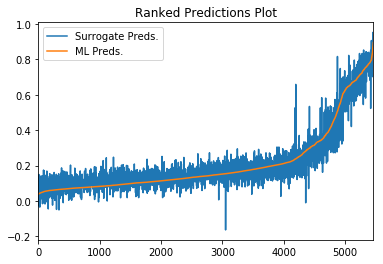

In [42]:
#22 - ranked predictions plot
pred_frame = local_glm2.predict(practical_sample).cbind(practical_sample).as_data_frame()[['predict', yhat  ]]

pred_frame.columns = ['Surrogate Preds.', 'ML Preds.']
pred_frame.sort_values(by='ML Preds.', inplace=True)
pred_frame.reset_index(inplace=True, drop=True)
_ = pred_frame.plot(title='Ranked Predictions Plot')

Both the R2 and ranked predictions plot show the linear model is a good fit in the practical, approximately local sample. This means that the regression coefficients are likely a very accurate representation of the behavior of the nonlinear model in this region.

7. Generate reason codes using a practical sample
Create explanations (or 'reason codes') for a row in the local set
Reason codes are generated for the model based on the practical sample, just as they were for the model based on the perturbed sample. Again, the woman's value for PAY_0 is the most important local contributor to her GBM prediction. As seen in other attempts to explain this prediction, PAY_0 followed by other payment variables, marital status, and her age play a role in the model decision.

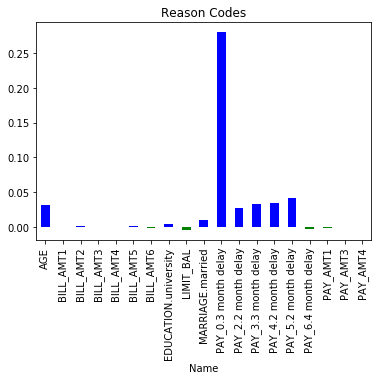

In [43]:
#23
plot_local_contrib(row, local_glm2, X)

Lets generate reason codes for values in row and coefficcients for model we just trainiend
Always keep in mind there's a random (approximate) element to all these interpretability techniques. So ideally you want to use all these techniques to build a narrative of agreement about what the model is saying. If no concensus then we should try to diagnose and fix.

ideally before shutting here we should save all artifacts of model by serializing.

Shut down H2O
After using H2O, it's typically best to shut it down. However, before doing so, users should ensure that they have saved any H2O data structures (such as models and H2OFrames) or scoring artifacts (such as POJOs and MOJOs).

In [44]:
#24 - be careful, this can erase your work!
h2o.cluster().shutdown(prompt=True)

Are you sure you want to shutdown the H2O instance running at http://localhost:54321 (Y/N)? y
H2O session _sid_a3d2 closed.


**Summary**

In this notebook, LIME was used to explain and generate reason codes for a complex GBM classifier. To do so, local linear models were fit to appropriate, representative samples, and linear model coefficients were used to explain the average behavior in the samples and to create reason codes. Reason codes were assessed against domain knowledge and reasonable expectations. A ranked prediction plot was also introduced to compare surrogate linear model predictions to GBM model predictions. These techniques should generalize well for many types of business and research problems, enabling you to train a complex machine learning model and analyze, validate, and explain it to your colleagues, bosses, and potentially, external regulators.